# Train end-to-end model with SSL4EO

In [1]:
cd ../

/cephyr/users/markpett/Alvis/ImputeAwareATE


In [2]:
import timm
import os
import torch
import pandas as pd
import numpy as np
import configparser
from tqdm import tqdm
from huggingface_hub import hf_hub_download
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Read config file
config = configparser.ConfigParser()
config.read('config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_imgs.csv'))

### Make folds

In [4]:
num_samples = len(df)
num_folds = 5

# Generate and shuffle indices
indices = np.arange(num_samples)
np.random.shuffle(indices)

# Split into 5 folds
folds = {}
fold_size = num_samples // num_folds
remainder = num_samples % num_folds  # For uneven splits

start = 0
for i in range(num_folds):
    end = start + fold_size + (1 if i < remainder else 0)  # Distribute remainder
    folds[chr(65 + i)] = list(indices[start:end])  # Fold names: 'A', 'B', ...
    start = end

# Save to JSON
#with open("simple_folds.json", "w") as f:
#    json.dump(folds, f, indent=2)

### Init model

Initiate model. For more info, see https://huggingface.co/torchgeo/ssl4eo_landsat/tree/main

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

repo_id = "torchgeo/ssl4eo_landsat"
filename = "resnet50_landsat_etm_sr_moco-1266cde3.pth"

# Download the model weights
backbone_path = hf_hub_download(repo_id=repo_id, filename=filename)

# Create backbone model
state_dict = torch.load(backbone_path)
ssl4eo_backbone = timm.create_model("resnet50", in_chans=6, num_classes=0)
ssl4eo_backbone.load_state_dict(state_dict)

# Define the model
model = nn.Sequential(
    ssl4eo_backbone,
    nn.Linear(2048, 1)
).to(device)

### Data loader

Code for dataloader

In [6]:
class RegressionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cluster_id = self.df.iloc[idx]['cluster_id']
        img_path = os.path.join(self.img_dir, cluster_id, 'landsat.np')
        img = np.load(img_path)
        target = (self.df.iloc[idx]['iwi'] / 100)
        if self.transform:
            img = self.transform(img)
        return img, target

In [7]:
test_fold = folds['A']  # Use fold A for testing
val_fold = folds['B']  # Use fold B for validation
train_folds = folds['C'] + folds['D'] + folds['E']  # Use folds C, D, E for training

In [ ]:
landsat_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 0.0000275 - 0.2),
    transforms.Lambda(lambda x: torch.clamp(x, 0.0, 0.3)),
    transforms.Lambda(lambda x: x / 0.3)
])

train_transform = transforms.Compose([
    landsat_transform,
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

img_dir = os.path.join(DATA_DIR, 'dhs_images')

train_dataset = RegressionDataset(df=df.iloc[train_folds], img_dir=img_dir, transform=train_transform)
val_dataset = RegressionDataset(df=df.iloc[val_fold], img_dir=img_dir, transform=landsat_transform)
test_dataset = RegressionDataset(df=df.iloc[test_fold], img_dir=img_dir, transform=landsat_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

Train model

In [ ]:
from torch.cuda.amp import GradScaler, autocast

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler()

num_epochs = 20

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device, dtype=torch.float32)
        targets = targets.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs).squeeze()  # remove extra dim if needed
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs = inputs.to(device, dtype=torch.float32)
            targets = targets.to(device, dtype=torch.float32)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_dataloader.dataset)
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")



  5%|▌         | 1/20 [10:04<3:11:21, 604.31s/it]

Epoch [1/20] - Train Loss: 0.0145, Val Loss: 0.0113


 10%|█         | 2/20 [15:31<2:12:27, 441.51s/it]

Epoch [2/20] - Train Loss: 0.0109, Val Loss: 0.0103


 10%|█         | 2/20 [42:50<6:25:33, 1285.18s/it]


KeyboardInterrupt: 

In [15]:
# Testing
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in tqdm(test_dataloader):
        inputs = inputs.to(device, dtype=torch.float32)
        targets = targets.to(device, dtype=torch.float32)
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
test_loss /= len(test_dataloader.dataset)
print(f"Test Loss: {test_loss:.4f}")

100%|██████████| 429/429 [01:24<00:00,  5.10it/s]

Test Loss: 0.0100


In [ ]:
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, targets in tqdm(test_dataloader):
        inputs = inputs.to(device, dtype=torch.float32)
        outputs = model(inputs).squeeze()
        y_true.extend(targets.numpy())
        y_pred.extend(outputs.cpu().numpy())
y_true = 100 * np.array(y_true)
y_pred = 100 * np.array(y_pred)

100%|██████████| 429/429 [04:50<00:00,  1.48it/s]


R^2 Score: 0.7249


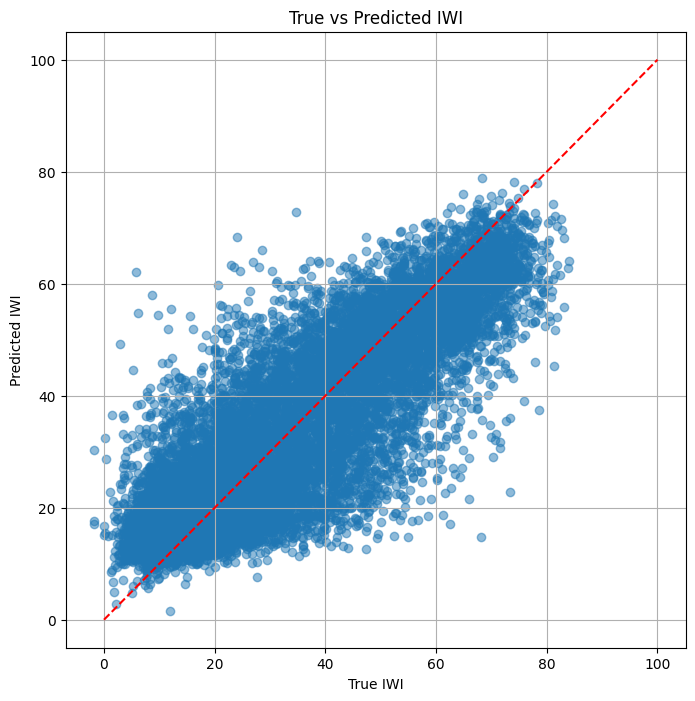

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 100], [0, 100], color='red', linestyle='--')
plt.xlabel('True IWI')
plt.ylabel('Predicted IWI')
plt.title('True vs Predicted IWI')
plt.grid()

# Get R^2
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
print(f"R^2 Score: {r2:.4f}")